In [1]:
import os

# Why Torch? You'll find the answer in the .md files! 
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
from models.hyperparameters import Hyperparameters

hp = Hyperparameters.load()
hp.image_size = (3, 224, 224)

In [4]:
hp.version

'1.0'

## Let's start simple
As theoretical evidence goes it is possible to aproximate any function
(see better references) by a simple NN. Unfortunally this is unfeasable
as the number of neurons should be a O(2e(d/3)) (check). 

Let's try to build a DNN (more than one layer) in order to achieve a good aproximation.

## HyperParameter: Image Size
What size should the image be? For sake of simplicity we want to consider all images to have the same size.

The more we reduce the size of an image the less information we contain as in most cases there will be a loss of information.
This loss of information while unavoidable can be actually desired as we can force the network to better generalize the features of the image.


### Memory Limits
My machine has an RTX3070Ti that only has 8GiB of VRAM and this has to be taken into account. Images can be very memory demaning as pointed out:
> It really depends on the size of your network and your GPU. You need to fit reasonably sized batch (16-64 images) in Gpu memory. That can easily be very big: you can compute the size of intermediate activations as 4 \* batch_size * num_feature_maps * height * width. Say you take 32 square images 112x112 with 64 feature maps. It would be 100Mb just for activations and the same amount for gradients. Take relatively big network (for example, VGG16) and you already need a few Gb.
Other aspect is the size of receptive field. If you follow current advices to prefer small filter size (3x3) and take big images, you can end up either with quite shallow network (because you can't fit a lot of layers into gpu) or with narrow network (which is ok if you know how to train it). Former network will necessarily have small effective receptive fields, therefore will approximate more local and simpler function.
So the rule of thumb is use images about 256x256 for ImageNet-scale networks and about 96x96 for something smaller and easier. I have heard that in kaggle people train on 512x512 sometimes, but you will need to compromise on something. Or just buy gpu cluster.
If you train fully convolutional networks like Faster RCNN you can take much bigger images (say 800x600) because you have batch size = 1.
> (https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network)


> https://arxiv.org/pdf/2103.09950.pdf Has interesting idea of learning the image size but I don't think it will be applied to this project.

In [4]:
import torchvision

loading_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((hp.image_size[1], hp.image_size[2])),
    torchvision.transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder("../../data/train", transform=loading_transforms)
validation_dataset = torchvision.datasets.ImageFolder("../../data/test/", transform=loading_transforms)


In [5]:
from models.build_model import build_model
from models.naive_dnn_gen.naive_dnn import naive_dnn_augmentation, naive_dnn

# A simple model definition
model = build_model(input_shape=hp.image_size, model=naive_dnn(input_shape=hp.image_size), name="naive_dnn")

# A model with also Augmentation procedure definition
# model = build_model(input_shape=hp.image_size, model=naive_dnn(input_shape=hp.image_size),
#                    augmentation=naive_dnn_augmentation(input_shape=hp.image_size), name="naive_dnn")

model.summary(expand_nested=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ naive_dnn (InputLayer)          │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 700)            │   105,370,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 250)            │       175,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,545,801 (402.63 MB)

 Trainable params: 105,545,801 (402.63 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
network_size = model.count_params()
image_batch_size = hp.image_size[0] * hp.image_size[1] * hp.image_size[2] * hp.batch_size
# https://huggingface.co/docs/transformers/v4.20.1/en/perf_train_gpu_one
# todo Find what it really is
optimizer_memory_impact = 4

print("Memory footprint of the model is around " + str(
    int((4 * (network_size + image_batch_size) * optimizer_memory_impact) / 1024 / 1024)) + " MB during training")


Memory footprint of the model is around 1684 MB during training


## Why Does Adadelta perform better than Adam in this problem?
I have no real explaination yet but it might be that Adam requires to scout for the best paramters to make it really effective. Study more on the subject.

In [7]:
from torch.utils.data import DataLoader
# todo fix
from models.zero_one_validation_loss import zero_one_loss_binary

import keras

train_dataloader = DataLoader(dataset=train_dataset, batch_size=hp.batch_size, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=hp.batch_size, shuffle=True)

# test on adagrad but change to adadelta
# adadelta went ok lets try adam. Adam sucks.
# Lets try LION as memory safer
model.compile(optimizer="adadelta", metrics=['accuracy'], loss="binary_crossentropy")

history = model.fit(train_dataloader, validation_data=validation_dataloader, epochs=hp.n_epochs, callbacks=[
    # To avoid keep going
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
])
#The other possible case is when the validation accuracy tracks the training accuracy fairly well. This case indicates that your model capacity is not high enough: make the model larger by increasing the number of parameters.
# https://cs231n.github.io/neural-networks-3/#gradcheck

# The network seems to be Overfitting as we (slowly) reach 100% (we got to 91%) 
# and loss is decaing but the val loss can't get under 0.4 (acc just went to 82% but no more)
model.save(f"compiled_model_{hp.version}.keras")

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 391ms/step - accuracy: 0.5773 - loss: 0.6953 - val_accuracy: 0.7120 - val_loss: 0.5919
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 386ms/step - accuracy: 0.6489 - loss: 0.6269 - val_accuracy: 0.6934 - val_loss: 0.5873
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.6778 - loss: 0.6034 - val_accuracy: 0.7179 - val_loss: 0.5520
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.6967 - loss: 0.5778 - val_accuracy: 0.7137 - val_loss: 0.5458
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.7068 - loss: 0.5625 - val_accuracy: 0.7154 - val_loss: 0.5479
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 388ms/step - accuracy: 0.7212 - loss: 0.5464 - val_accuracy: 0.7466 - val_loss: 0.5212
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 388ms/step - accuracy: 0.7288 - loss: 0.5355 - val_accuracy: 0.7340 - val_loss: 0.5518
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.7540 -

https://arxiv.org/abs/2305.19982#:~:text=Evaluated%20on%20transformer%2Dbased%20models,2%25%20degradation%20in%20training%20throughput.
An alternative to Adam

<Axes: >

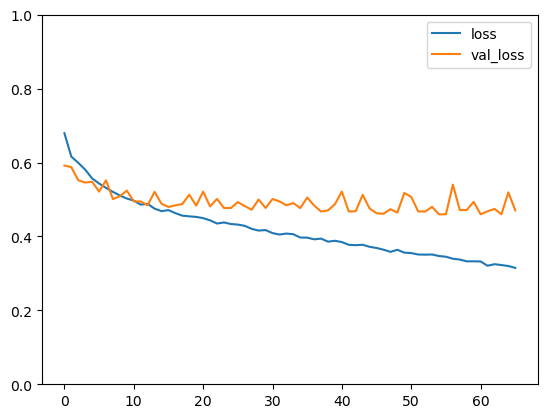

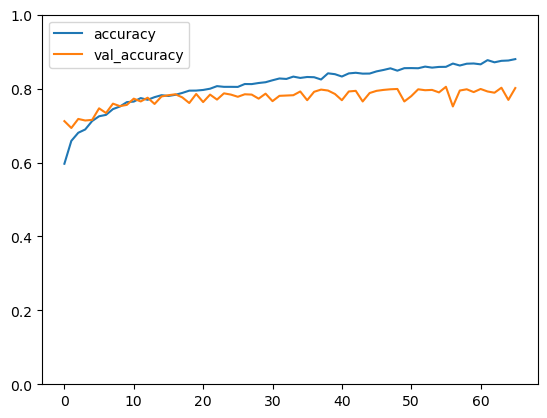

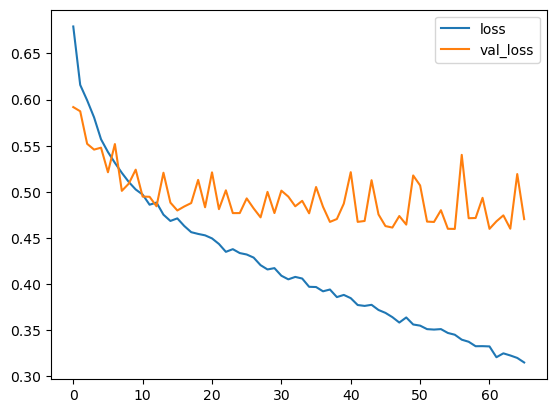

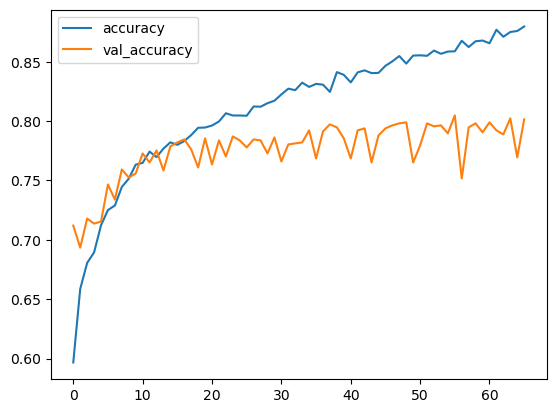

In [10]:
import pandas

metrics_df1 = pandas.DataFrame(history.history)
metrics_df1[["loss", "val_loss"]].plot(ylim=(0, 1))
metrics_df1[["accuracy", "val_accuracy"]].plot(ylim=(0, 1))
metrics_df1[["loss", "val_loss"]].plot()
metrics_df1[["accuracy", "val_accuracy"]].plot()

# For the 2 Hidden Layers with 2.9k / 1.1k Neurons Layers the Network is prone to Overfitting 
# as we can deduce by the fact that we had to early stop since the validation loss 
# hasn't gotten any better for a long period of time (10 Epoches)

In [9]:
metrics_df1

,accuracy,loss,val_accuracy,val_loss
0,0.596662,0.679256,0.711993,0.591860
1,0.658567,0.615925,0.693412,0.587340
2,0.680541,0.599196,0.717905,0.552049
3,0.689415,0.580668,0.713682,0.545779
4,0.712233,0.556985,0.715372,0.547860
...,...,...,...,...
61,0.877034,0.320700,0.792230,0.468009
62,0.871118,0.324897,0.788851,0.474478
63,0.875132,0.322601,0.802365,0.460027
64,0.875977,0.319936,0.769426,0.519261


In [14]:
# Seems like the model is overfitting for 3500/1350 units


## Second Attempt with dropout
In order to reduce the bias of the network towards training samples we introduce a dropout layer. This in order to reduce overfitting.

In [15]:
# Second Model  (With dropout)
input_shape: (int, int, int)

input_layer = keras.Input(shape=input_shape, name='naive_dnn')
x = keras.layers.Flatten()(input_layer)

x = keras.layers.Dense(units=3500, activation='relu')(x)
x = keras.layers.Dropout(rate=0.5)(x)
x = keras.layers.Dense(units=1350, activation='relu')(x)

output_layer = keras.layers.Dense(units=1, activation='sigmoid')(x)

NameError: name 'input_shape' is not defined

Problem is, as we could assume before, that the NN is not able to really learn all the features of the training data, and we tend therefore to underfit. (in my opionion and the opinion of the uni course)

We need more nodes to better learn the structure of data.
Should we add nodes or an additional layer?

## Third Attempt: Super simple
We are overfitting it seems. Let's see performance on fewer neurons:


In [ ]:
input_layer = keras.Input(shape=input_shape, name='naive_dnn')
x = keras.layers.Flatten()(input_layer)

x = keras.layers.Dense(units=1000, activation='relu')(x)
x = keras.layers.Dense(units=300, activation='relu')(x)

output_layer = keras.layers.Dense(units=1, activation='sigmoid')(x)

We slowly hit the 90% accuracy while the validation one not so good. It only hits a 80% and loss wont get below 0.45